## Problem Statement

To identify the better model between Logistic Regression and Naive Bayes, based on their accuracies in classifying reddit posts into two categories, namely "iOS Programming" subreddit and "Developing Android Apps" subreddit.

## Executive Summary

Reddit posts were scraped from two subreddit threads, "iOS Programming" and "Developing Android Apps". These reddit posts were then pre-processed before being separately trained on the Logistic Regression and the Multinomial Naive Bayes classifier. Initially, before feature engineering was performed, the Logistic Regression algorithm outperformed the Multinomial Naive Bayes algorithm. However, after feature engineering was performed, in which the selftext and title of each posts were merged, the Multinomial Naive Bayes algorithm outperformed the Logistic Regression.

### Contents:
- [Import libraries](#Import-libraries)
- [Import data](#Import-data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [Further Modeling](#Further-Modeling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import regex as re

from bs4 import BeautifulSoup
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords # Import the stop word list

import imp
plotting_util = imp.load_source('plotting_util', './plotting_utilities.py')
from plotting_util import Plotter
plotter = Plotter()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/dev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/dev/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import data

In [2]:
android_df = pd.read_csv('../data/android_dev.csv')
android_df.drop(['Unnamed: 0'], axis=1, inplace=True)
android_df.drop_duplicates(keep = 'first', inplace = True) 
android_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,androiddev,Looking for Android developers? Heard about a ...,t2_6l4z3,False,NaN,0,False,"Weekly ""who's hiring"" thread!",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,androiddev,This thread is for simple questions that don't...,t2_6l4z3,False,NaN,0,False,"Weekly Questions Thread - January 20, 2020",[],...,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
2,NaN,androiddev,NaN,t2_iassk,False,NaN,0,False,Telegram-like theme switching with reveal anim...,"[{'e': 'text', 't': 'Article'}]",...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,254cc416-e885-11e4-b88d-22000bc18061,NaN,NaN,NaN,NaN
3,NaN,androiddev,NaN,t2_3vf8x,False,NaN,0,False,The Power of Types for Errors,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,androiddev,NaN,t2_45tfbxxq,False,NaN,0,False,Everything you need to know about Memory Leaks...,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN


In [3]:
ios_df = pd.read_csv('../data/ios_programming.csv')
ios_df.drop(['Unnamed: 0'], axis=1, inplace=True)
ios_df.drop_duplicates(keep = 'first', inplace = True) 
ios_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,iOSProgramming,Welcome to r/iOSProgramming! Click the links b...,t2_3h859,False,NaN,0,False,READ BEFORE POSTING / Megathread Hub,"[{'e': 'text', 't': 'Announcement'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.578431e+09,0,NaN,False,NaN,NaN,NaN,NaN
1,NaN,iOSProgramming,Welcome to the weekly r/iOSProgramming simple ...,t2_6l4z3,False,NaN,0,False,"Simple Questions Megathread—January 13, 2020","[{'e': 'text', 't': 'Weekly'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.578946e+09,0,NaN,False,NaN,NaN,NaN,NaN
2,NaN,iOSProgramming,NaN,t2_dw88zzd,False,NaN,0,False,Pull to Refresh in SwiftUI,"[{'e': 'text', 't': 'Article'}]",...,https://link.medium.com/1QgLlY4ho3,66427,1.579486e+09,0,NaN,False,NaN,NaN,NaN,NaN
3,NaN,iOSProgramming,Keeping up with the newest frameworks and tool...,t2_3hizc4vt,False,NaN,0,False,Developer's Guide to Common Vulnerabilities an...,"[{'e': 'text', 't': 'Article'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.579524e+09,0,NaN,False,NaN,NaN,NaN,NaN
4,NaN,iOSProgramming,People tell me there are 10x more web jobs tha...,t2_kgbts,False,NaN,0,False,Is there a shortage of iOS Developers?,"[{'e': 'text', 't': 'Question'}]",...,https://www.reddit.com/r/iOSProgramming/commen...,66427,1.579452e+09,0,NaN,False,NaN,NaN,NaN,NaN


In [4]:
combined_df = pd.concat([android_df, ios_df], sort=False)
combined_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,media_metadata,author_cakeday
0,NaN,androiddev,Looking for Android developers? Heard about a ...,t2_6l4z3,False,NaN,0,False,"Weekly ""who's hiring"" thread!",[],...,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,androiddev,This thread is for simple questions that don't...,t2_6l4z3,False,NaN,0,False,"Weekly Questions Thread - January 20, 2020",[],...,0,NaN,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
2,NaN,androiddev,NaN,t2_iassk,False,NaN,0,False,Telegram-like theme switching with reveal anim...,"[{'e': 'text', 't': 'Article'}]",...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,254cc416-e885-11e4-b88d-22000bc18061,NaN,NaN,NaN,NaN
3,NaN,androiddev,NaN,t2_3vf8x,False,NaN,0,False,The Power of Types for Errors,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN
4,NaN,androiddev,NaN,t2_45tfbxxq,False,NaN,0,False,Everything you need to know about Memory Leaks...,[],...,0,NaN,False,link,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,NaN,NaN


## Pre-processing

In [5]:
combined_df.isnull().sum()

approved_at_utc           1960
subreddit                    0
selftext                   526
author_fullname              6
saved                        0
                          ... 
link_flair_template_id    1019
crosspost_parent_list     1919
crosspost_parent          1919
media_metadata            1883
author_cakeday            1955
Length: 109, dtype: int64

In [6]:
combined_df['author_flair_type'].value_counts()

text        1848
richtext     106
Name: author_flair_type, dtype: int64

In [7]:
combined_df['link_flair_type'].value_counts()

richtext    1059
text         901
Name: link_flair_type, dtype: int64

In [8]:
combined_df['subreddit'] = combined_df['subreddit'].map({'androiddev': 1, 'iOSProgramming': 0})

In [9]:
combined_df = combined_df[['id', 'title', 'name', 'media', 
                           'is_video', 'permalink', 'author_flair_type',
                           'link_flair_type', 'created', 'created_utc', 'selftext',
                           'author_fullname', 'subreddit']]

## Exploratory Data Analysis

In [10]:
df_1 = combined_df.copy()

In [11]:
df_1.dropna(subset=['selftext'], inplace=True)

In [12]:
# Import lemmatizer
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_post):
    # Function to convert a raw reddit post to a string of words
    # The input is a single string (a raw reddit post), and 
    # the output is a single string (a preprocessed reddit post)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    letters_only = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', letters_only)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

**Android**

In [13]:
df_1_android = df_1.loc[df_1['subreddit'] == 1]

In [14]:
df_1_android['selftext'] = df_1_android['selftext'].apply(review_to_words)

In [15]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_1_android['selftext'])

len_features = len(cvec.get_feature_names())
print('Number of features: {}'.format(len_features))

df_1_android_cv = pd.DataFrame(cvec.transform(df_1_android['selftext']).todense(),columns=cvec.get_feature_names())

top_android = df_1_android_cv.sum(axis=0)
top_android.sort_values(ascending = False).head(20)

Number of features: 6596


app        910
android    805
https      519
com        484
google     348
apps       282
use        254
like       251
using      234
new        234
java       218
play       207
know       202
want       179
code       179
store      172
make       159
user       155
way        155
need       141
dtype: int64

In [16]:
df_top_android = top_android.to_frame(name='count')
df_top_android['word'] = df_top_android.index
df_top_android.reset_index(drop=True, inplace=True)
df_top_android['freq'] = df_top_android['count'] / len(df_1_android)

cols = ['word','count','freq']
df_top_android = df_top_android[cols]
df_top_android.sort_values(by='count',ascending=False, inplace=True)
df_top_android.head(10)

,word,count,freq
309,app,910,1.256906
247,android,805,1.111878
2804,https,519,0.716851
1066,com,484,0.668508
2560,google,348,0.480663
353,apps,282,0.389503
6247,use,254,0.350829
3380,like,251,0.346685
6263,using,234,0.323204
3915,new,234,0.323204


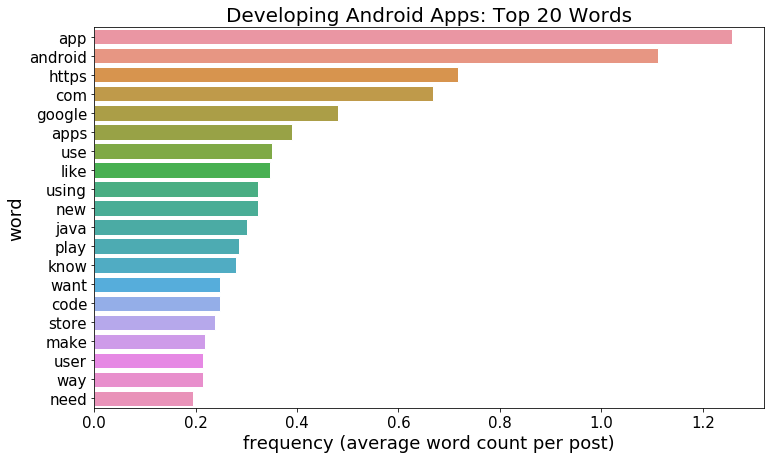

In [17]:
plotter.plot_horizontal_barchart("Developing Android Apps: Top 20 Words", df_top_android)
plt.savefig('../images/barchart_top20words_android.png', transparent=True)

**iOS**

In [18]:
df_1_ios = df_1.loc[df_1['subreddit'] == 0]

In [19]:
df_1_ios['selftext'] = df_1_ios['selftext'].apply(review_to_words)

In [20]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_1_ios['selftext'])

len_features = len(cvec.get_feature_names())
print('Number of features: {}'.format(len_features))

df_1_ios_cv = pd.DataFrame(cvec.transform(df_1_ios['selftext']).todense(),columns=cvec.get_feature_names())

top_ios = df_1_ios_cv.sum(axis=0)
top_ios.sort_values(ascending = False).head(20)

Number of features: 6407


app          823
https        387
com          359
ios          348
like         270
view         248
use          239
apple        234
using        220
let          217
time         213
code         206
data         187
want         185
swift        179
know         178
help         162
new          157
xcode        153
developer    148
dtype: int64

In [21]:
df_top_ios = top_ios.to_frame(name='count')
df_top_ios['word'] = df_top_ios.index
df_top_ios.reset_index(drop=True, inplace=True)
df_top_ios['freq'] = df_top_ios['count'] / len(df_1_ios)

cols = ['word','count','freq']
df_top_ios = df_top_ios[cols]
df_top_ios.sort_values(by='count',ascending=False, inplace=True)
df_top_ios.head(10)

,word,count,freq
264,app,823,1.159155
2612,https,387,0.545070
1003,com,359,0.505634
2895,ios,348,0.490141
3170,like,270,0.380282
6158,view,248,0.349296
6057,use,239,0.336620
276,apple,234,0.329577
6080,using,220,0.309859
3147,let,217,0.305634


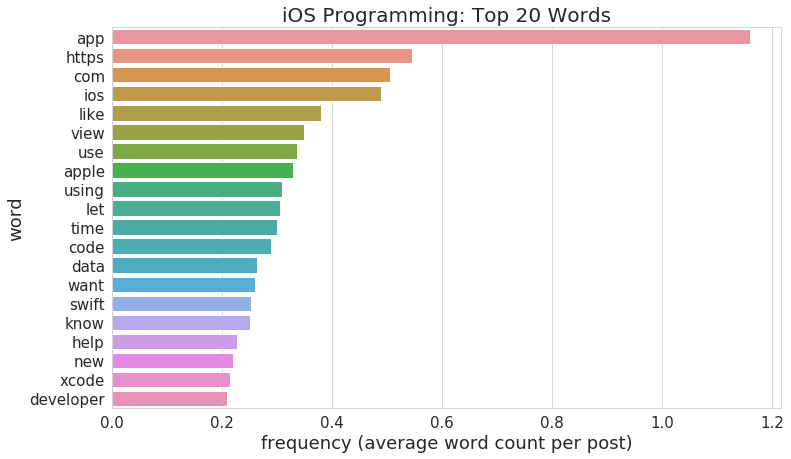

In [22]:
plotter.plot_horizontal_barchart("iOS Programming: Top 20 Words", df_top_ios)
plt.savefig('../images/barchart_top20words_ios.png', transparent=True)

## Modeling

### Baseline Accuracy

In [23]:
df_1['subreddit'].value_counts(normalize=True)

1    0.504881
0    0.495119
Name: subreddit, dtype: float64

In [24]:
X = df_1['selftext'].apply(review_to_words)
y = df_1['subreddit']

In [25]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state = 42)

### Multinomial Naive Bayes

In [26]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [27]:
pipe_params = {
#     'cvec__tokenizer': [lemmatizer.lemmatize, p_stemmer.stem],
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train) # gs.fit(X_train['selftext'], y_train)
print(gs.best_score_)
gs.best_params_

0.843718066427019


{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [28]:
# Probabilities for positive class
pos_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[0, :].argsort()

# Probabilities for negative class
neg_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[1, :].argsort()

In [29]:
# Getting the top features 
pos_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), neg_class_prob_sorted)

In [30]:
# Top 20 features for the positive class
pos_top_features[:20].tolist()

['zip',
 'maintain subreddit',
 'major',
 'make effort',
 'make top',
 'manifest',
 'claim',
 'may open',
 'mediation',
 'members',
 'message compose',
 'messaging',
 'messaging app',
 'checking sidebar',
 'midi',
 'clean architecture',
 'migrate',
 'migration code',
 'mistake',
 'mod']

In [31]:
# Top 20 features for the negative class
neg_top_features[:20].tolist()

['getting started',
 'forums developer',
 'catch print',
 'catalina',
 'testflight',
 'validation',
 'frame width',
 'frequent',
 'var body',
 'func',
 'func collectionview',
 'func viewdidload',
 'textfield',
 'vc',
 'objective questions',
 'protocols',
 'videos play',
 'objc',
 'view controller',
 'view controllers']

**Classification Metrics**

In [32]:
gs.score(X_train, y_train) 

0.9646511627906976

In [33]:
gs.score(X_test, y_test)

0.841225626740947

In [34]:
predictions = gs.predict(X_test)

In [35]:
confusion_matrix(y_test, predictions)

array([[148,  30],
       [ 27, 154]])

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [37]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 148
False Positives: 30
False Negatives: 27
True Positives: 154


In [38]:
def get_classification_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    misclassification = 1 - accuracy
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print("Accuracy: %s" % accuracy)
    print("Misclassification: %s" % misclassification)
    print("Sensitivity: %s" % sensitivity)
    print("Specificity: %s" % specificity)
    print("Precision: %s" % precision)

In [39]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.841225626740947
Misclassification: 0.15877437325905297
Sensitivity: 0.850828729281768
Specificity: 0.8314606741573034
Precision: 0.8369565217391305


In [40]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pred_proba})

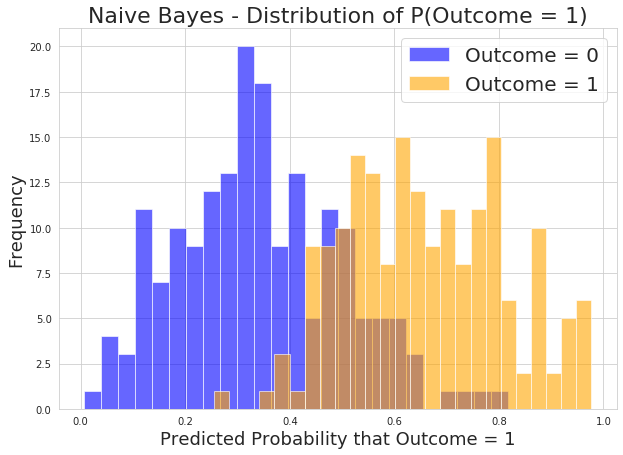

In [41]:
plotter.plot_probability_distribution(pred_df, "Naive Bayes")
plt.savefig('../images/probdist_naivebayes_before.png', transparent=True)

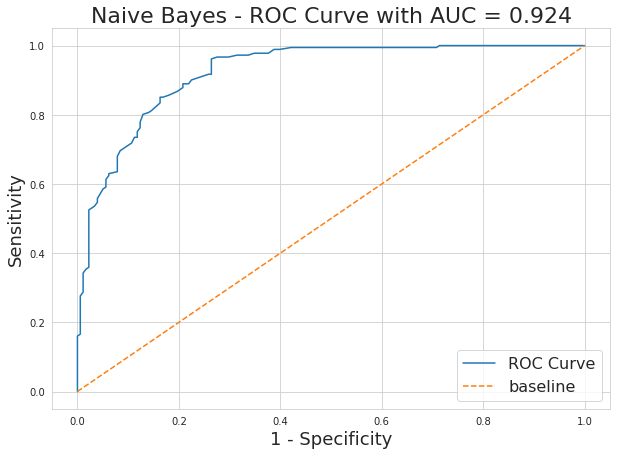

In [42]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Naive Bayes")
plt.savefig('../images/roc_naivebayes_before.png', transparent=True)

### Logistic Regression

In [43]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=5000))
])

In [44]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2']
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8632503903352474


{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__penalty': 'l2'}

**Inference**

In [45]:
selected_features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

In [46]:
selected_features_coefs_exp = np.exp(gs.best_estimator_.named_steps['lr'].coef_[0])

In [47]:
sorted(list(zip(selected_features, selected_features_coefs_exp)), key=lambda tup: tup[1], reverse=True)[:20]

[('android', 148.28226933691494),
 ('google', 10.858312034375848),
 ('java', 4.99204916288152),
 ('play', 4.630544257529272),
 ('kotlin', 3.852591866409019),
 ('admob', 3.6875078728289226),
 ('activity', 3.1588379067275674),
 ('play store', 2.8967934597022515),
 ('fragment', 2.8914991638755065),
 ('android studio', 2.646387730670579),
 ('ad', 2.623421731342117),
 ('google play', 2.606727719053449),
 ('studio', 2.573258999059603),
 ('game', 2.445534970378542),
 ('recyclerview', 2.308592556954895),
 ('phone', 2.1643323041377687),
 ('mobile', 2.1551372867377965),
 ('apk', 2.107244383730634),
 ('etc', 2.0207771741842446),
 ('images', 1.9654854101105192)]

A unit change in the tf-idf score of the word "android" results in an approximately 141 times increase in likelihood of the post belong the subreddit "Developing Android Apps"

**Classification Metrics**

In [48]:
gs.score(X_train, y_train)

0.9823255813953489

In [49]:
gs.score(X_test, y_test)

0.8495821727019499

In [50]:
predictions = gs.predict(X_test)

In [51]:
confusion_matrix(y_test, predictions)

array([[152,  26],
       [ 28, 153]])

In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [53]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 152
False Positives: 26
False Negatives: 28
True Positives: 153


In [54]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8495821727019499
Misclassification: 0.1504178272980501
Sensitivity: 0.8453038674033149
Specificity: 0.8539325842696629
Precision: 0.8547486033519553


In [55]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

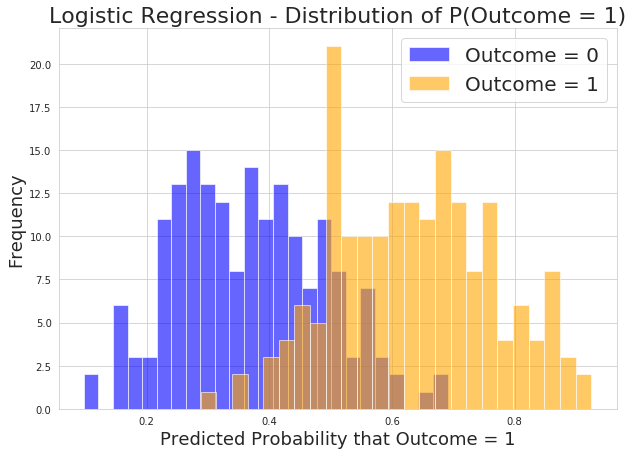

In [56]:
plotter.plot_probability_distribution(pred_df, "Logistic Regression")
plt.savefig('../images/probdist_logreg_before.png', transparent=True)

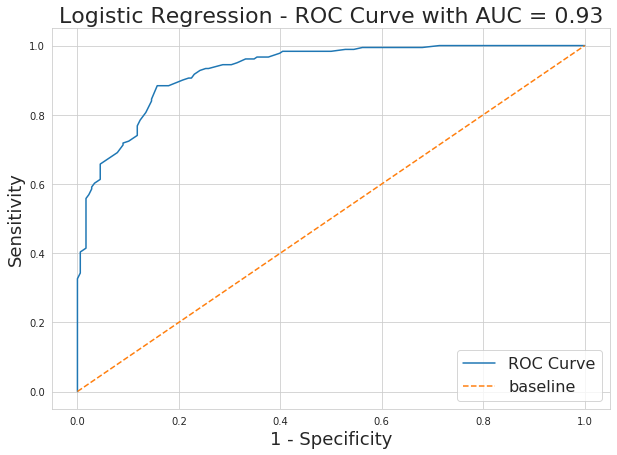

In [57]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Logistic Regression")
plt.savefig('../images/roc_logreg_before.png', transparent=True)

## Further Modeling

### Feature Engineering

In [58]:
df_2 = combined_df.copy()

In [59]:
df_2[['title', 'selftext']].isnull().sum()

title         0
selftext    526
dtype: int64

Since there is no null value in the title variable, we convert null values in the selftext variable to empty strings.

In [60]:
df_2['content'] = df_2['title'] + " " + df_2['selftext'].fillna('')

### Baseline Accuracy

In [61]:
df_2['subreddit'].value_counts(normalize=True)

1    0.50051
0    0.49949
Name: subreddit, dtype: float64

In [62]:
df_2.columns

Index(['id', 'title', 'name', 'media', 'is_video', 'permalink',
       'author_flair_type', 'link_flair_type', 'created', 'created_utc',
       'selftext', 'author_fullname', 'subreddit', 'content'],
      dtype='object')

In [63]:
X = df_2['content'].apply(review_to_words)
y = df_2['subreddit']

In [64]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state = 42)

### Multinomial Naive Bayes

In [65]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [66]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train) # gs.fit(X_train['selftext'], y_train)
print(gs.best_score_)
gs.best_params_

0.8680272108843538


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [67]:
# Probabilities for positive class
pos_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[0, :].argsort()

# Probabilities for negative class
neg_class_prob_sorted = gs.best_estimator_.named_steps['nb'].feature_log_prob_[1, :].argsort()

In [68]:
# Getting the top features 
pos_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), pos_class_prob_sorted)
neg_top_features = np.take(gs.best_estimator_.named_steps['cvec'].get_feature_names(), neg_class_prob_sorted)

In [69]:
# Top 20 features for the positive class
pos_top_features[:20].tolist()

['inject',
 'com posting',
 'name android',
 'please paste',
 'initialize',
 'stores',
 'commenters',
 'comments consider',
 'store pages',
 'store listing',
 'ndk',
 'industry',
 'still allowed',
 'steal',
 'indexing',
 'compose',
 'compose fr',
 'stats',
 'strike',
 'income']

In [70]:
# Top 20 features for the negative class
neg_top_features[:20].tolist()

['table view',
 'rxswift',
 'baseurl search',
 'work equity',
 'safari',
 'touchbar',
 'megathread',
 'use thread',
 'samplebuffer',
 'megathread december',
 'sandbox',
 'find beginner',
 'use xcode',
 'running courses',
 'megathread hub',
 'iphones',
 'ipados',
 'save everyone',
 'completion escaping',
 'ipad']

**Classification Metrics**

In [71]:
gs.score(X_train, y_train) 

0.9653061224489796

In [72]:
gs.score(X_test, y_test)

0.8877551020408163

In [73]:
predictions = gs.predict(X_test)

In [74]:
confusion_matrix(y_test, predictions)

array([[229,  16],
       [ 39, 206]])

In [75]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [76]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 229
False Positives: 16
False Negatives: 39
True Positives: 206


In [77]:
def get_classification_metrics(tn, fp, fn, tp):
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    misclassification = 1 - accuracy
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    print("Accuracy: %s" % accuracy)
    print("Misclassification: %s" % misclassification)
    print("Sensitivity: %s" % sensitivity)
    print("Specificity: %s" % specificity)
    print("Precision: %s" % precision)

In [78]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8877551020408163
Misclassification: 0.11224489795918369
Sensitivity: 0.8408163265306122
Specificity: 0.9346938775510204
Precision: 0.9279279279279279


In [79]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pred_proba})

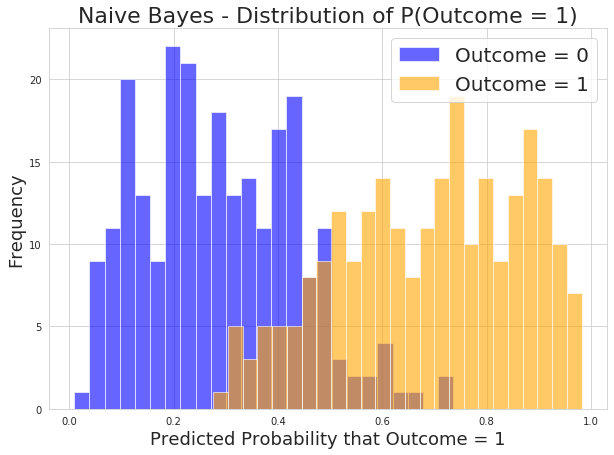

In [80]:
plotter.plot_probability_distribution(pred_df, "Naive Bayes")
plt.savefig('../images/probdist_naivebayes_after.png', transparent=True)

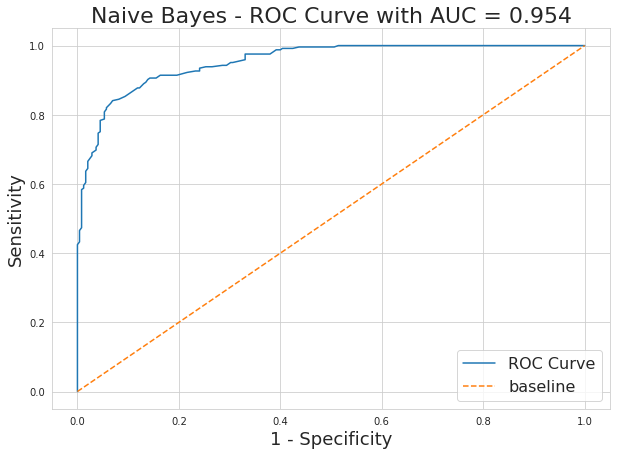

In [81]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Naive Bayes")
plt.savefig('../images/roc_naivebayes_after.png', transparent=True)

### Logistic Regression

In [82]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=5000))
])

In [83]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 4000, 4500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8802721088435375


{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

**Inference**

In [84]:
selected_features = gs.best_estimator_.named_steps['cvec'].get_feature_names()

In [85]:
selected_features_coefs_exp = np.exp(gs.best_estimator_.named_steps['lr'].coef_[0])

In [86]:
sorted(list(zip(selected_features, selected_features_coefs_exp)), key=lambda tup: tup[1], reverse=True)[:20]

[('android', 879.2826122321815),
 ('google', 19.4776390729306),
 ('kotlin', 8.695350578934352),
 ('java', 7.385585314566653),
 ('admob', 6.724834671861537),
 ('play', 5.28606100187019),
 ('emulator', 4.086187345625469),
 ('library', 3.697701262222655),
 ('activity', 3.6453625830685046),
 ('play store', 3.453161705832043),
 ('android studio', 3.250628471548507),
 ('studio', 3.19083008953339),
 ('google play', 3.1270150883449017),
 ('dagger', 3.0783835694468595),
 ('room', 2.963949116464888),
 ('fragment', 2.8418119443026626),
 ('fragments', 2.7421593017377757),
 ('jetpack', 2.6894456450328517),
 ('ad', 2.663138627015133),
 ('game', 2.610082484460937)]

A unit change in the tf-idf score of the word "android" results in an approximately 898 times increase in likelihood of the post belong the subreddit "Developing Android Apps"

**Classification Metrics**

In [87]:
gs.score(X_train, y_train)

0.9768707482993197

In [88]:
gs.score(X_test, y_test)

0.8693877551020408

In [89]:
predictions = gs.predict(X_test)

In [90]:
confusion_matrix(y_test, predictions)

array([[225,  20],
       [ 44, 201]])

In [91]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [92]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 225
False Positives: 20
False Negatives: 44
True Positives: 201


In [93]:
get_classification_metrics(tn, fp, fn, tp)

Accuracy: 0.8693877551020408
Misclassification: 0.1306122448979592
Sensitivity: 0.8204081632653061
Specificity: 0.9183673469387755
Precision: 0.9095022624434389


In [94]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

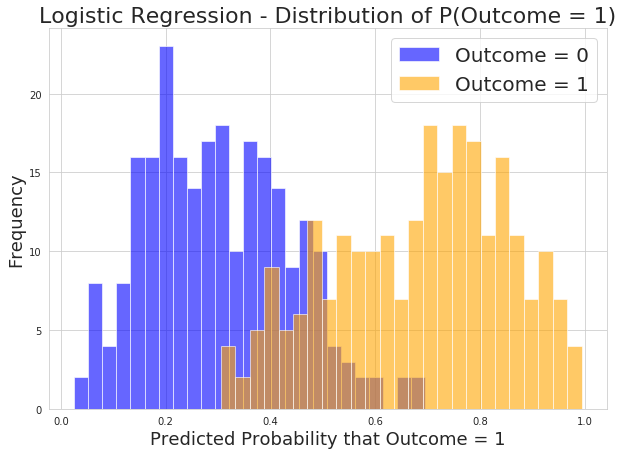

In [95]:
plotter.plot_probability_distribution(pred_df, "Logistic Regression")
plt.savefig('../images/probdist_logreg_after.png', transparent=True)

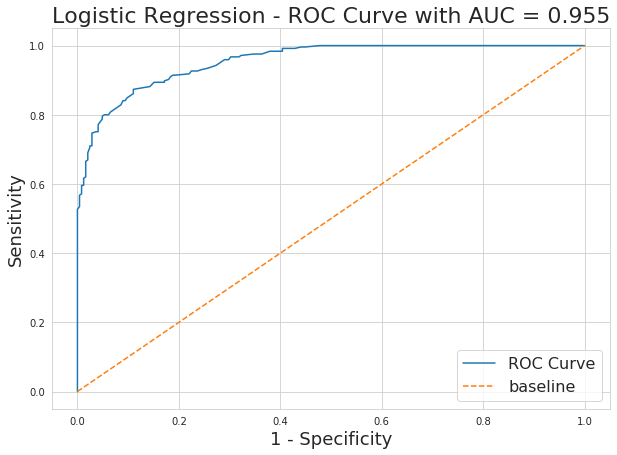

In [96]:
plotter.plot_roc_curve(pred_df=pred_df, classifier_name="Logistic Regression")
plt.savefig('../images/roc_logreg_after.png', transparent=True)

## Conclusions and Recommendations

The classification metrics of the models used are as follows:

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=2>Before Feature Engineering</th>
            <th colspan=2>After Feature Engineering</th>
        </tr>
        <tr>
            <th>Metrics</th>
            <th>Naive Bayes</th>
            <th>Logistic Regression</th>
            <th>Naive Bayes</th>
            <th>Logistic Regression</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Accuracy</td>
            <td>0.841</td>
            <td>0.850</td>
            <td>0.888</td>
            <td>0.869</td>
        </tr>
        <tr>
            <td>Misclassification</td>
            <td>0.159</td>
            <td>0.150</td>
            <td>0.112</td>
            <td>0.131</td>
        </tr>
        <tr>
            <td>Sensitivity</td>
            <td>0.851</td>
            <td>0.845</td>
            <td>0.841</td>
            <td>0.820</td>
        </tr>
        <tr>
            <td>Specificity</td>
            <td>0.831</td>
            <td>0.854</td>
            <td>0.935</td>
            <td>0.918</td>
        </tr>
        <tr>
            <td>Precision</td>
            <td>0.837</td>
            <td>0.855</td>
            <td>0.928</td>
            <td>0.910</td>
        </tr>
    </tbody>
</table>

It can be observed that the accuracy of the Logistic Regression classifier was higher than the accuracy of the Naive Bayes classifier before feature engineering was performed.

After feature engineering was performed, where the title and selftext was added together, the Naive Bayes classifier outperformed the Logistic Regression classifier in terms of accuracy.

Based on these findings, it is recommended that the title and selftext are both factored into the Naive Bayes classifier for the highest classification accuracy when classifying reddit posts as either of the two subreddit threads, "Developing Android Apps" and "iOS Programming".